# INTER PATIENT PERFORMANCE EVALUATION

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
import tensorflow as tf
import tensorflow_addons as tfa
from os.path import join as osj
import pandas as pd
import seaborn as sns
import random
import pickle
import os

## Load and transform performance results

In [54]:
def load_results(m):
    with open(osj(f"../results_dp/{m}/interpatient_results.pkl"), 'rb') as f:
        results = pickle.load(f)
    with open(osj(f"../results_dp/{m}/interpatient_loss.pkl"), 'rb') as f:
        loss = pickle.load(f)
    return results, loss

Transforming the results and losses into dataframes for evaluation.

In [55]:
dp_methods = ["laplace", "bounded_n", "gaussian_a"]
loss_records = []
result_records = []

for mechanism in dp_methods:

    # Load results and loss per mechanism
    mechanism_results, mechanism_loss = load_results(mechanism)

    # Extract loss
    for epsilon, deltas in mechanism_loss.items():
        for delta, epochs in deltas.items():

            last_epoch = max(epochs.keys()) if epochs else None  
            if last_epoch is None:
                continue 
            
            batches = epochs[last_epoch]
            last_batch = max(batches.keys()) if batches else None  
            if last_batch is None:
                continue
            
            loss = batches[last_batch]
            loss_records.append({
                "Model": f"Inter-{mechanism}",
                "Epsilon": epsilon,
                "Delta": delta,
                "Loss": loss
            })

    # ALL EPSILON VALUES
    # hp_epsilon_values = [0.001, 0.01, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081, 0.091,
    #                             0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 
    #                     1.01, 1.11, 1.21, 1.31, 1.41, 1.51, 1.61, 1.71, 1.81, 1.91, 2.01]
    # hp_delta_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    # TRAINED EPSILON VALUES
    hp_epsilon_values = [0.001, 0.01, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081, 0.091, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91]

    dict_mechanism_results = {epsilon: mechanism_results[epsilon] for epsilon in hp_epsilon_values if epsilon in mechanism_results}

    # Extract results
    for epsilon, deltas in dict_mechanism_results.items():
        for delta, epochs in deltas.items():
            if epochs is None:
                continue
            else:
                for epoch, metrics in epochs.items():
                    for metric, values in metrics.items():
                        if metric == "avg_acc":
                            continue
                        else:
                            result_records.append({"Model": f"Inter-{mechanism}", "Epsilon": epsilon, "Delta": delta, "Epoch": epoch, "Metric": metric, "N": values[0], "S": values[1], "V": values[2]})


df_results = pd.DataFrame(result_records)
df_losses = pd.DataFrame(loss_records)

In [56]:
# Adding anothere column with the class averages for all metrics
df_results.loc[:,"class_average"] = df_results[["N", "S", "V"]].mean(axis=1)

In [57]:
df_results

,Model,Epsilon,Delta,Epoch,Metric,N,S,V,class_average
0,Inter-laplace,0.001,0.1,9,acc,0.951789,0.952114,0.994228,0.966043
1,Inter-laplace,0.001,0.1,9,sens,0.987545,0.049288,0.931592,0.656142
2,Inter-laplace,0.001,0.1,9,spec,0.638635,0.986913,0.998608,0.874719
3,Inter-laplace,0.001,0.1,9,prec,0.959894,0.126761,0.979085,0.688580
4,Inter-laplace,0.001,0.1,9,neg_pred_value,0.854112,0.964199,0.995232,0.937848
...,...,...,...,...,...,...,...,...,...
42385,Inter-gaussian_a,0.910,1.0,99,neg_pred_value,0.908989,0.995712,1.000000,0.968234
42386,Inter-gaussian_a,0.910,1.0,99,false_pos_rate,0.035303,0.009712,0.001109,0.015375
42387,Inter-gaussian_a,0.910,1.0,99,false_neg_rate,0.011029,0.110022,0.000000,0.040350
42388,Inter-gaussian_a,0.910,1.0,99,false_det_rate,0.004059,0.219675,0.015659,0.079798


Filter for only last epoch to reduce the dataframe size (skip, if all epochs are needed)

In [58]:
df_results_last = df_results.copy()
df_results_last = df_results_last[df_results_last['Epoch'] == 99]

In [59]:
df_results_last.drop(columns=["Epoch"], inplace=True)
df_results_last

,Model,Epsilon,Delta,Metric,N,S,V,class_average
81,Inter-laplace,0.001,0.1,acc,0.951382,0.952866,0.994207,0.966152
82,Inter-laplace,0.001,0.1,sens,0.985960,0.026144,0.971928,0.661344
83,Inter-laplace,0.001,0.1,spec,0.648553,0.988789,0.995760,0.877701
84,Inter-laplace,0.001,0.1,prec,0.960892,0.082902,0.941105,0.661633
85,Inter-laplace,0.001,0.1,neg_pred_value,0.840617,0.963226,0.998039,0.933960
...,...,...,...,...,...,...,...,...
42385,Inter-gaussian_a,0.910,1.0,neg_pred_value,0.908989,0.995712,1.000000,0.968234
42386,Inter-gaussian_a,0.910,1.0,false_pos_rate,0.035303,0.009712,0.001109,0.015375
42387,Inter-gaussian_a,0.910,1.0,false_neg_rate,0.011029,0.110022,0.000000,0.040350
42388,Inter-gaussian_a,0.910,1.0,false_det_rate,0.004059,0.219675,0.015659,0.079798


In [ ]:
# f1_results = df_results[df_results["Metric"] == "f1_score"]
# f1_results

,Model,Epsilon,Delta,Epoch,Metric,N,S,V,class_average
8,Inter-laplace,0.001,0.1,9,f1_score,0.973523,0.070978,0.954748,0.666416
17,Inter-laplace,0.001,0.1,19,f1_score,0.971508,0.037629,0.897392,0.635510
26,Inter-laplace,0.001,0.1,29,f1_score,0.928417,0.108933,0.941534,0.659628
35,Inter-laplace,0.001,0.1,39,f1_score,0.974084,0.018877,0.944486,0.645816
44,Inter-laplace,0.001,0.1,49,f1_score,0.972551,0.058528,0.946108,0.659062
...,...,...,...,...,...,...,...,...,...
39113,Inter-gaussian_a,0.910,1.0,59,f1_score,0.984038,0.701162,0.996561,0.893920
39122,Inter-gaussian_a,0.910,1.0,69,f1_score,0.988328,0.765552,0.984389,0.912756
39131,Inter-gaussian_a,0.910,1.0,79,f1_score,0.988101,0.631357,0.995203,0.871554
39140,Inter-gaussian_a,0.910,1.0,89,f1_score,0.995176,0.882770,0.999377,0.959108


## Loss evaluation

In [8]:
df_losses

,Model,Epsilon,Delta,Loss
0,Inter-laplace,0.001,0.1,0.010204
1,Inter-laplace,0.001,0.2,0.005666
2,Inter-laplace,0.001,0.3,0.005022
3,Inter-laplace,0.001,0.4,0.004940
4,Inter-laplace,0.001,0.5,0.005745
...,...,...,...,...
158,Inter-gaussian_a,0.041,0.8,0.005666
159,Inter-gaussian_a,0.041,0.9,0.005250
160,Inter-gaussian_a,0.041,1.0,0.006295
161,Inter-gaussian_a,0.051,0.1,0.005316


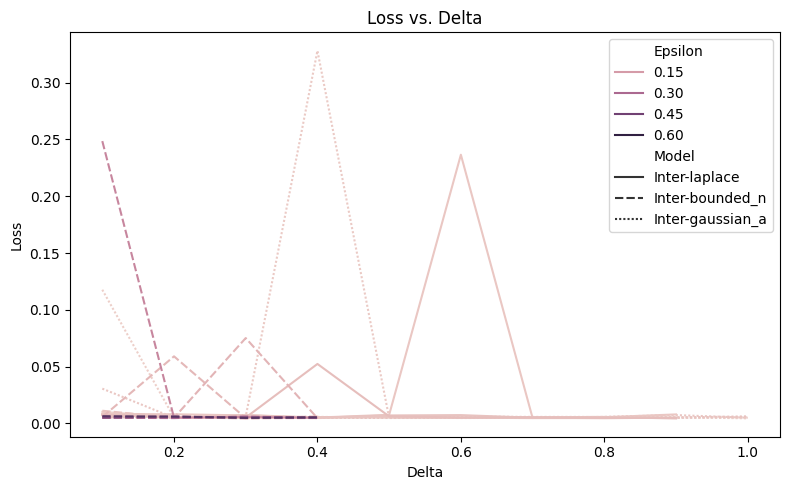

In [9]:
plt.figure(figsize=(8, 5))

sns.lineplot( 
    data = df_losses,
    x ="Delta", 
    y = "Loss", 
    hue = "Epsilon",
    style = "Model"
)

plt.xlabel("Delta")
plt.ylabel("Loss")
plt.title("Loss vs. Delta")
plt.legend()
plt.tight_layout()
plt.show()

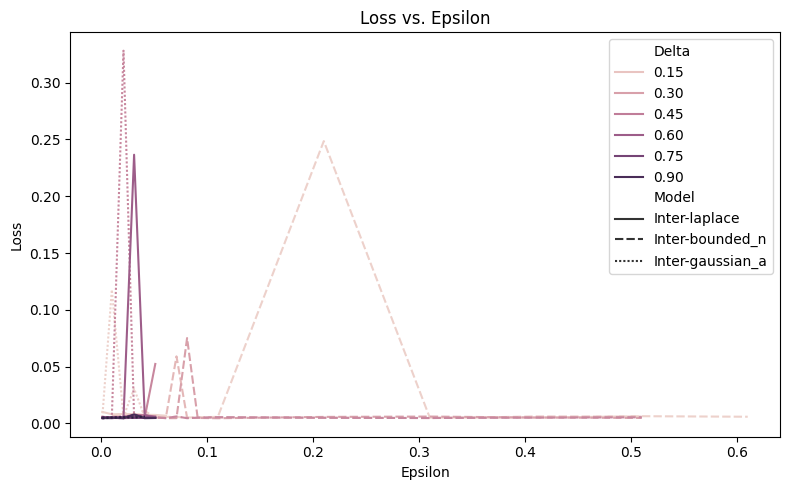

In [10]:
plt.figure(figsize=(8, 5))

sns.lineplot( 
    data = df_losses,
    x ="Epsilon", 
    y = "Loss", 
    hue = "Delta",
    style = "Model"
)

plt.xlabel("Epsilon")
plt.ylabel("Loss")
plt.title("Loss vs. Epsilon")
plt.legend()
plt.tight_layout()
plt.show()

## Performance evaluation

### Stats ( best and worst mechanism performances )

In [60]:
df_results_f1 = df_results_last[df_results_last["Metric"] == "f1_score"]

#### on average

In [61]:
# ---- Best in total ----
# Get the best setup for the model
best_total = df_results_f1.loc[df_results_f1["class_average"].idxmax()]
# best_total
# --> 
# Model            Intra-laplace
# Epsilon                  0.051
# Delta                      0.8
# Metric                f1_score
# F                          1.0
# N                          1.0
# S                          1.0
# V                          1.0
# class_average              1.0

# Get the n best setups for the model
best_n = df_results_f1.nlargest(5, "class_average")
# best_n
# --> TOP 14 have 1.0 for everything 


# ---- Worst in total ----
# Get the worst setup for the model
last_total = df_results_f1.loc[df_results_f1["class_average"].idxmin()]
# last_total
# --> 
# Model            Intra-laplace
# Epsilon                  0.001
# Delta                      0.0
# Metric                f1_score
# F                          NaN
# N                     0.906463
# S                     0.033389
# V                     0.052938
# class_average          0.33093

# Get the n worst setups for the model
last_n = df_results_f1.nsmallest(5, "class_average")
# last_n
# --> true DP is the worst

In [62]:
# best_total
best_n

# last_total
# last_n

,Model,Epsilon,Delta,Metric,N,S,V,class_average
41399,Inter-gaussian_a,0.810,0.9,f1_score,0.998064,0.954782,0.997828,0.983558
37169,Inter-gaussian_a,0.410,0.2,f1_score,0.997451,0.946939,0.994127,0.979505
33749,Inter-gaussian_a,0.091,0.4,f1_score,0.996817,0.926247,0.996740,0.973268
15479,Inter-laplace,0.610,0.6,f1_score,0.996681,0.921361,0.997514,0.971852
4769,Inter-laplace,0.041,0.9,f1_score,0.996386,0.912798,0.999063,0.969416


In [63]:
attack_setups = best_n[["Model", "Epsilon", "Delta"]].drop_duplicates() # 5 best setups
attack_setups = pd.concat([attack_setups, last_n[["Model", "Epsilon", "Delta"]]], ignore_index=True) # worst 5 setups

len(attack_setups)
# 10 in total

10

In [64]:
relevant_metrics = ["f1_score", "acc", "sens", "spec", "prec"]

# ---- Best in total (all metrics) ----
best_keys = best_n[["Model", "Epsilon", "Delta"]]

mask_best = df_results_last.set_index(["Model", "Epsilon", "Delta"]).index.isin(best_keys.set_index(["Model", "Epsilon", "Delta"]).index)
best_keys_details = df_results_last[mask_best]
best_keys_details = best_keys_details[best_keys_details["Metric"].isin(relevant_metrics)]


# ---- Last in total (all metrics) ----
last_key = last_n[["Model", "Epsilon", "Delta"]]

mask_last = df_results_last.set_index(["Model", "Epsilon", "Delta"]).index.isin(last_key.set_index(["Model", "Epsilon", "Delta"]).index)
last_key_details = df_results_last[mask_last]
last_key_details = last_key_details[last_key_details["Metric"].isin(relevant_metrics)]

In [65]:
best_keys_details

,Model,Epsilon,Delta,Metric,N,S,V,class_average
4761,Inter-laplace,0.041,0.9,acc,0.993516,0.993394,0.999878,0.995596
4762,Inter-laplace,0.041,0.9,sens,0.995833,0.926471,0.998129,0.973477
4763,Inter-laplace,0.041,0.9,spec,0.973225,0.995989,1.000000,0.989738
4764,Inter-laplace,0.041,0.9,prec,0.996939,0.899524,1.000000,0.965488
4769,Inter-laplace,0.041,0.9,f1_score,0.996386,0.912798,0.999063,0.969416
15471,Inter-laplace,0.610,0.6,acc,0.994045,0.994126,0.999675,0.995948
15472,Inter-laplace,0.610,0.6,sens,0.996602,0.922113,0.998134,0.972283
15473,Inter-laplace,0.610,0.6,spec,0.971694,0.996918,0.999783,0.989465
15474,Inter-laplace,0.610,0.6,prec,0.996760,0.920609,0.996894,0.971421
15479,Inter-laplace,0.610,0.6,f1_score,0.996681,0.921361,0.997514,0.971852


In [15]:
last_key_details

,Model,Epsilon,Delta,Metric,N,S,V,class_average
891,Inter-laplace,0.001,0.0,acc,0.868659,0.956585,0.909228,0.911490
892,Inter-laplace,0.001,0.0,sens,0.964454,0.005476,0.018715,0.329548
893,Inter-laplace,0.001,0.0,spec,0.027821,0.993245,0.971301,0.664122
894,Inter-laplace,0.001,0.0,prec,0.896989,0.030303,0.043478,0.323590
899,Inter-laplace,0.001,0.0,f1_score,0.929499,0.009276,0.026167,0.321647
1881,Inter-laplace,0.010,0.0,acc,0.845894,0.929085,0.910711,0.895230
1882,Inter-laplace,0.010,0.0,sens,0.934312,0.059913,0.034204,0.342810
1883,Inter-laplace,0.010,0.0,spec,0.073239,0.962778,0.972012,0.669343
1884,Inter-laplace,0.010,0.0,prec,0.898062,0.058729,0.078740,0.345177
1889,Inter-laplace,0.010,0.0,f1_score,0.915829,0.059315,0.047691,0.340945


#### per mechanism

In [66]:
# ---- Best grouped by DP method ----
# # Get the best epsilon for each method
best_method = df_results_f1.loc[df_results_f1.groupby("Model")["class_average"].idxmax()]
# best_method

# # Get the top 2 rows per Method based on F1 score
best_n_method = df_results_f1.groupby("Model", group_keys=False).apply(
    lambda n: n.nlargest(3, "class_average")
)
# best_n_method

# ---- Best grouped specifically for Laplace (delta = 0.0) ----
# Get the bext for true DP Laplace
laplace = df_results_f1[(df_results_f1["Model"] == "Inter-laplace") & (df_results_f1["Delta"] == 0.0)]
laplace_best_n = laplace.nlargest(3, "class_average")
# laplace_best_n


# ---- Worst grouped by DP method ----
# # Get the worst epsilon for each method
last_method = df_results_f1.loc[df_results_f1.groupby("Model")["class_average"].idxmax()]
# last_method

# # Get the last 2 rows per Method based on F1 score
last_n_method = df_results_f1.groupby("Model", group_keys=False).apply(
    lambda n: n.nsmallest(3, "class_average")
)
# last_n_method

# ---- Worst grouped specifically for Laplace (delta > 0.0) ----
# Get the worst for approximate Laplace
laplace = df_results_f1[(df_results_f1["Model"] == "Inter-laplace") & (df_results_f1["Delta"] != 0.0)]
laplace_last_n = laplace.nsmallest(3, "class_average")
# laplace_last_n

/tmp/ipykernel_2986112/680310504.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_n_method = df_results_f1.groupby("Model", group_keys=False).apply(
/tmp/ipykernel_2986112/680310504.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  last_n_method = df_results_f1.groupby("Model", group_keys=False).apply(


In [67]:
# best_method
# best_n_method
# laplace_best_n

# last_method
last_n_method
# laplace_last_n

,Model,Epsilon,Delta,Metric,N,S,V,class_average
21149,Inter-bounded_n,0.071,0.2,f1_score,0.927442,0.396452,0.816244,0.713379
19259,Inter-bounded_n,0.021,0.1,f1_score,0.980721,0.182613,0.978035,0.713790
18899,Inter-bounded_n,0.010,0.1,f1_score,0.974653,0.292282,0.982285,0.749740
26639,Inter-gaussian_a,0.010,0.5,f1_score,0.979869,0.032154,0.998755,0.670259
28979,Inter-gaussian_a,0.041,0.1,f1_score,0.980130,0.119344,0.996283,0.698585
40139,Inter-gaussian_a,0.710,0.5,f1_score,0.981466,0.179208,0.996426,0.719033
899,Inter-laplace,0.001,0.0,f1_score,0.929499,0.009276,0.026167,0.321647
2879,Inter-laplace,0.021,0.0,f1_score,0.917253,0.009191,0.082699,0.336381
1889,Inter-laplace,0.010,0.0,f1_score,0.915829,0.059315,0.047691,0.340945


In [68]:
attack_setups = pd.concat([attack_setups, best_n_method[["Model", "Epsilon", "Delta"]]], ignore_index=True) # best 3 each
attack_setups = pd.concat([attack_setups, laplace_best_n[["Model", "Epsilon", "Delta"]]], ignore_index=True) # best 3 for true laplace

attack_setups = pd.concat([attack_setups, last_n_method[["Model", "Epsilon", "Delta"]]], ignore_index=True) # worst 3 each
attack_setups = pd.concat([attack_setups, laplace_last_n[["Model", "Epsilon", "Delta"]]], ignore_index=True) # worst 3 for approximate laplace
len(attack_setups)

34

In [69]:
attack_setups.drop_duplicates(inplace=True)
attack_setups.reset_index(drop=True, inplace=True)
attack_setups

,Model,Epsilon,Delta
0,Inter-gaussian_a,0.810,0.9
1,Inter-gaussian_a,0.410,0.2
2,Inter-gaussian_a,0.091,0.4
3,Inter-laplace,0.610,0.6
4,Inter-laplace,0.041,0.9
5,Inter-laplace,0.001,0.0
6,Inter-laplace,0.021,0.0
7,Inter-laplace,0.010,0.0
8,Inter-laplace,0.031,0.0
9,Inter-laplace,0.041,0.0


In [70]:
attack_setups.to_csv("../results_dp/attack_setup_inter.csv", index=False)

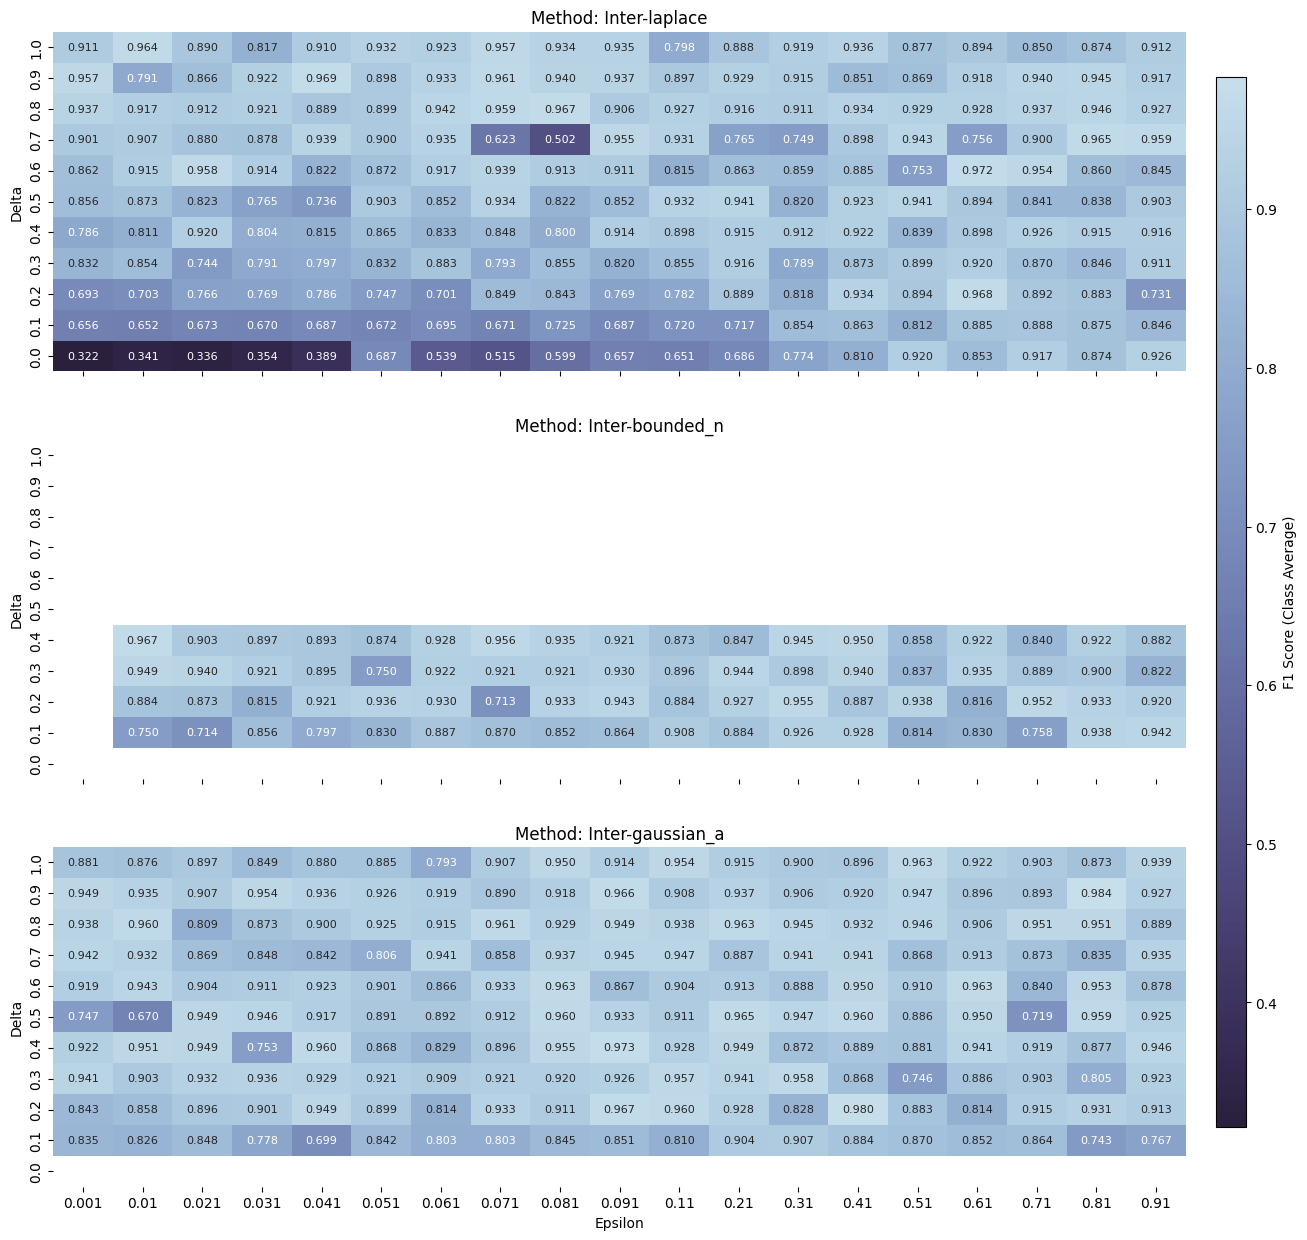

In [32]:
# Get unique Model, Epsilon and Delta
models = df_results_f1["Model"].unique()
epsilon_order = sorted(df_results_f1["Epsilon"].unique())
delta_order = sorted(df_results_f1["Delta"].unique(), reverse=True)

fig, axes = plt.subplots(len(models), 1, figsize=(15, 5 * len(models)), sharex=True)

# Normalize color scale across all models
vmin = df_results_f1["class_average"].min()
vmax = df_results_f1["class_average"].max()

from matplotlib.cm import ScalarMappable
import matplotlib as mpl
# cmap = sns.color_palette("light:#5A9_r", as_cmap=True)
cmap = sns.color_palette("ch:s=.25,rot=-.25_r", as_cmap=True)
# cmap = sns.color_palette("dark:#5A9", as_cmap=True)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap=cmap)

for i, model in enumerate(models):
    model_df = df_results_f1[df_results_f1["Model"] == model]

    # Create pivot table for heatmap: rows = Delta, columns = Epsilon, values = class_average
    pivot_table = model_df.pivot_table(
        index="Delta",
        columns="Epsilon",
        values="class_average"
    ).reindex(index=delta_order, columns=epsilon_order)

    sns.heatmap(
        pivot_table,
        ax=axes[i],
        annot=True,
        fmt=".3f",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        cbar=False,
        annot_kws={"size": 8}
    )

    axes[i].set_title(f"Method: {model}")
    axes[i].set_ylabel("Delta")
    if i == len(models) - 1:
        axes[i].set_xlabel("Epsilon")
    else:
        axes[i].set_xlabel("")
        axes[i].set_xticklabels([]) 


plt.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7]) 
fig.colorbar(sm, cax=cbar_ax).set_label("F1 Score (Class Average)")

# plt.tight_layout()
plt.show()


#### per class

In [ ]:
# ---- Best per Class ----
best_per_class = pd.concat([
    df_results_f1.loc[df_results_f1[cls].idxmax()]
    for cls in ["F", "N", "S", "V"]
], axis=1).T
# best_per_class

top_k_per_class = {}
for cls in ["N", "S", "V"]:
    top_k = df_results_f1.sort_values(by=cls, ascending=False).head(3)
    top_k_per_class[cls] = top_k
# top_k_per_class


# ---- Worst per Class ----
last_per_class = pd.concat([
    df_results_f1.loc[df_results_f1[cls].idxmin()]
    for cls in ["F", "N", "S", "V"]
], axis=1).T
# last_per_class

last_k_per_class = {}
for cls in ["N", "S", "V"]:
    last_k = df_results_f1.sort_values(by=cls, ascending=True).head(3)
    last_k_per_class[cls] = last_k
# last_k_per_class

In [ ]:
# print(top_k_per_class['N'])
# print(top_k_per_class['S'])
print(top_k_per_class['V'])

                  Model  Epsilon  Delta    Metric         N         S  \
37529  Inter-gaussian_a     0.81    0.2  f1_score  0.992379  0.799882   
9269      Inter-laplace     0.31    0.5  f1_score  0.984146  0.476577   
11699     Inter-laplace     0.51    1.0  f1_score  0.984133  0.648241   

              V  class_average  
37529  0.999379       0.930547  
9269   0.999379       0.820034  
11699  0.999379       0.877251  


In [ ]:
# print(last_k_per_class['N'])
# print(last_k_per_class['S'])
# print(last_k_per_class['V'])

              Model  Epsilon  Delta    Metric         N         S         V  \
899   Inter-laplace    0.001    0.0  f1_score  0.929499  0.009276  0.026167   
1889  Inter-laplace    0.010    0.0  f1_score  0.915829  0.059315  0.047691   
2879  Inter-laplace    0.021    0.0  f1_score  0.917253  0.009191  0.082699   

      class_average  
899        0.321647  
1889       0.340945  
2879       0.336381  


In [ ]:
# del df_results # to save memory

### Comaparison of delta for epsilon = 0.01 ( for all mechanisms ) per class

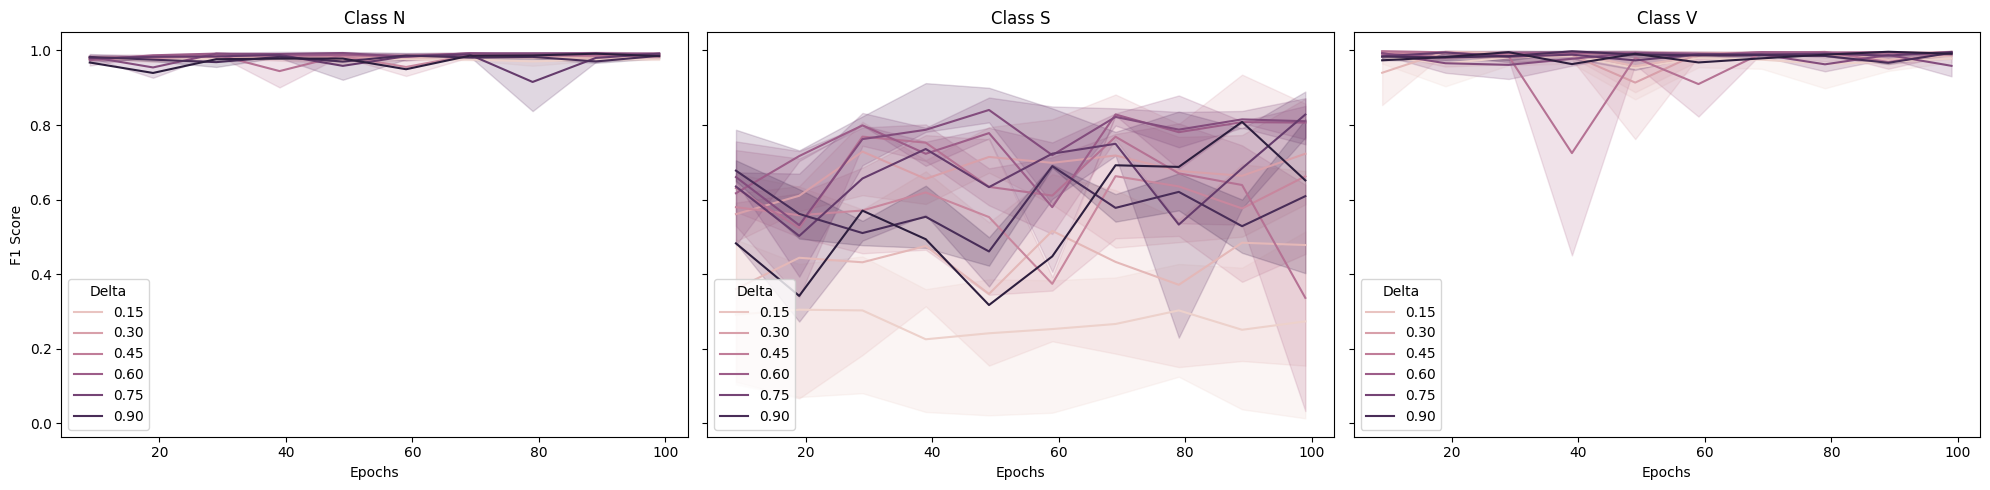

In [13]:
# Comparing F1 score of different deltas for each class

f1_epsilon = df_results[(df_results["Metric"] == "f1_score") & (df_results["Epsilon"] == 0.01)]
classes = ["N", "S", "V"]

fig, axes = plt.subplots(1, len(classes), figsize=(20, 5), sharey=True)
for i, cls in enumerate(classes):
    sns.lineplot(
        data=f1_epsilon,
        x="Epoch",
        y=cls,
        hue="Delta",
        ax=axes[i]
    )
    axes[i].set_title(f"Class {cls}")
    axes[i].set_xlabel("Epochs")

axes[0].set_ylabel("F1 Score")
axes[-1].legend(title="Delta")

plt.tight_layout()
plt.show()

### F1 Score vs. Epochs -- by DP-Mechanism and Class

#### -- comparing delta for epsilon 0.01

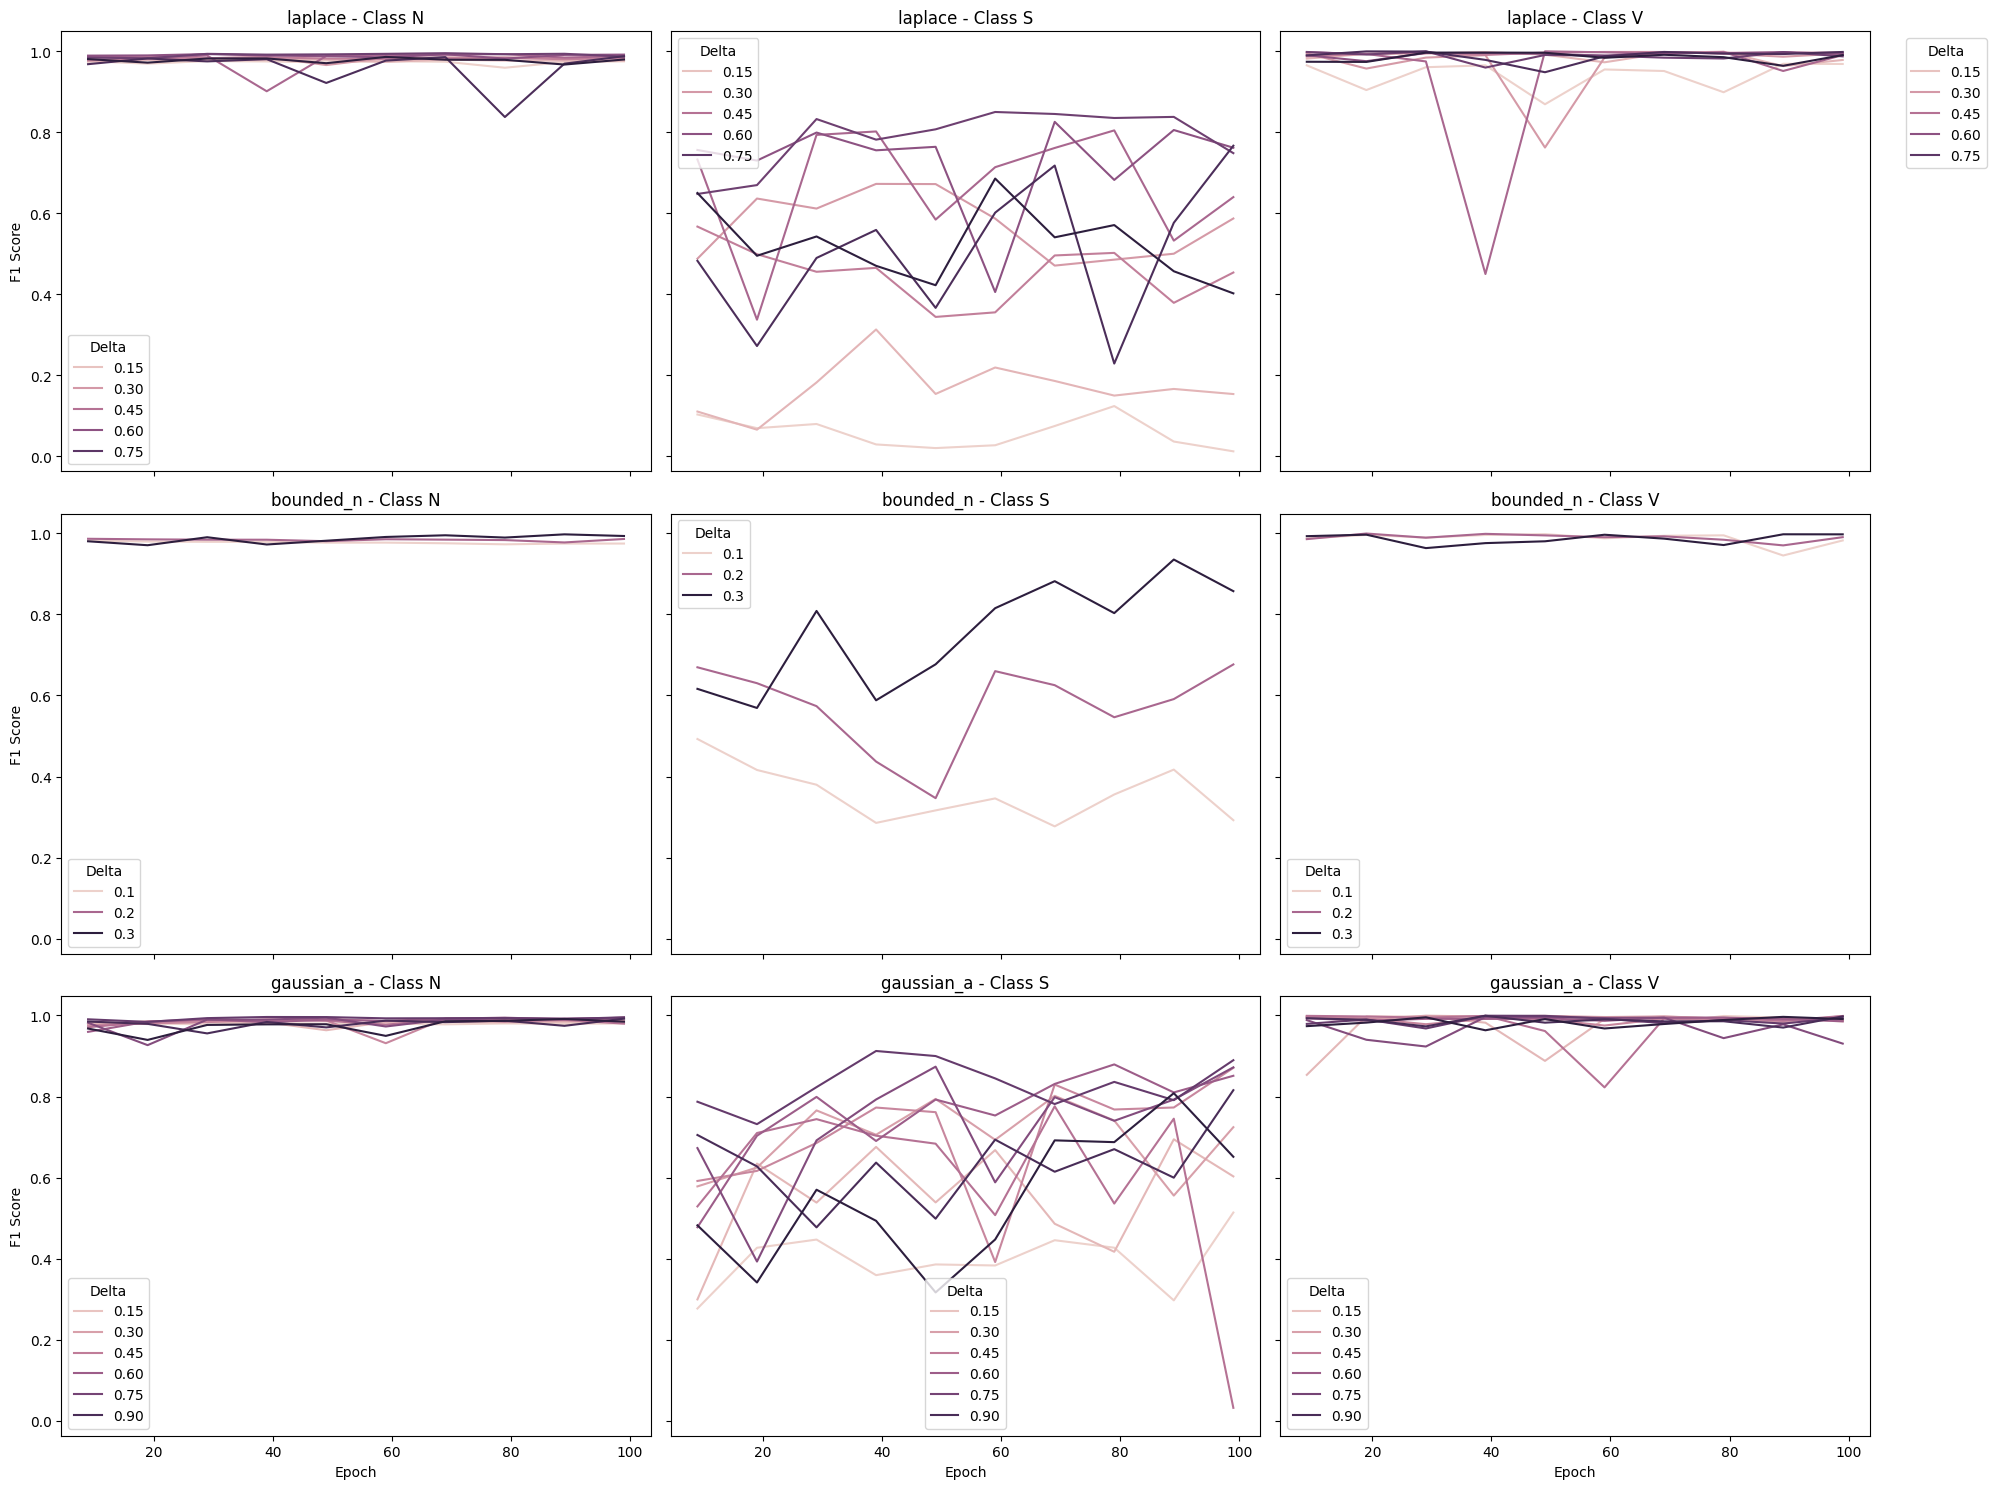

In [15]:
f1_results = df_results[(df_results["Metric"] == "f1_score") & (df_results["Epsilon"] == 0.01)]
classes = ["N", "S", "V"]

fig, axes = plt.subplots(len(dp_methods), len(classes), figsize=(20, 5 * len(dp_methods)), sharex=True, sharey=True)

for row_idx, method in enumerate(dp_methods):
    for col_idx, cls in enumerate(classes):
        ax = axes[row_idx][col_idx] if len(dp_methods) > 1 else axes[col_idx]

        subset = f1_results[f1_results["Model"] == f"Inter-{method}"]

        sns.lineplot(
            data=subset,
            x="Epoch",
            y=cls,
            hue="Delta",
            ax=ax
        )
        ax.set_title(f"{method} - Class {cls}")
        ax.set_xlabel("Epoch")
        if col_idx == 0:
            ax.set_ylabel("F1 Score")
        else:
            ax.set_ylabel("")

        if row_idx == 0 and col_idx == len(classes) - 1:
            ax.legend(title="Delta", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


#### -- comparing epsilon for delta 0.4

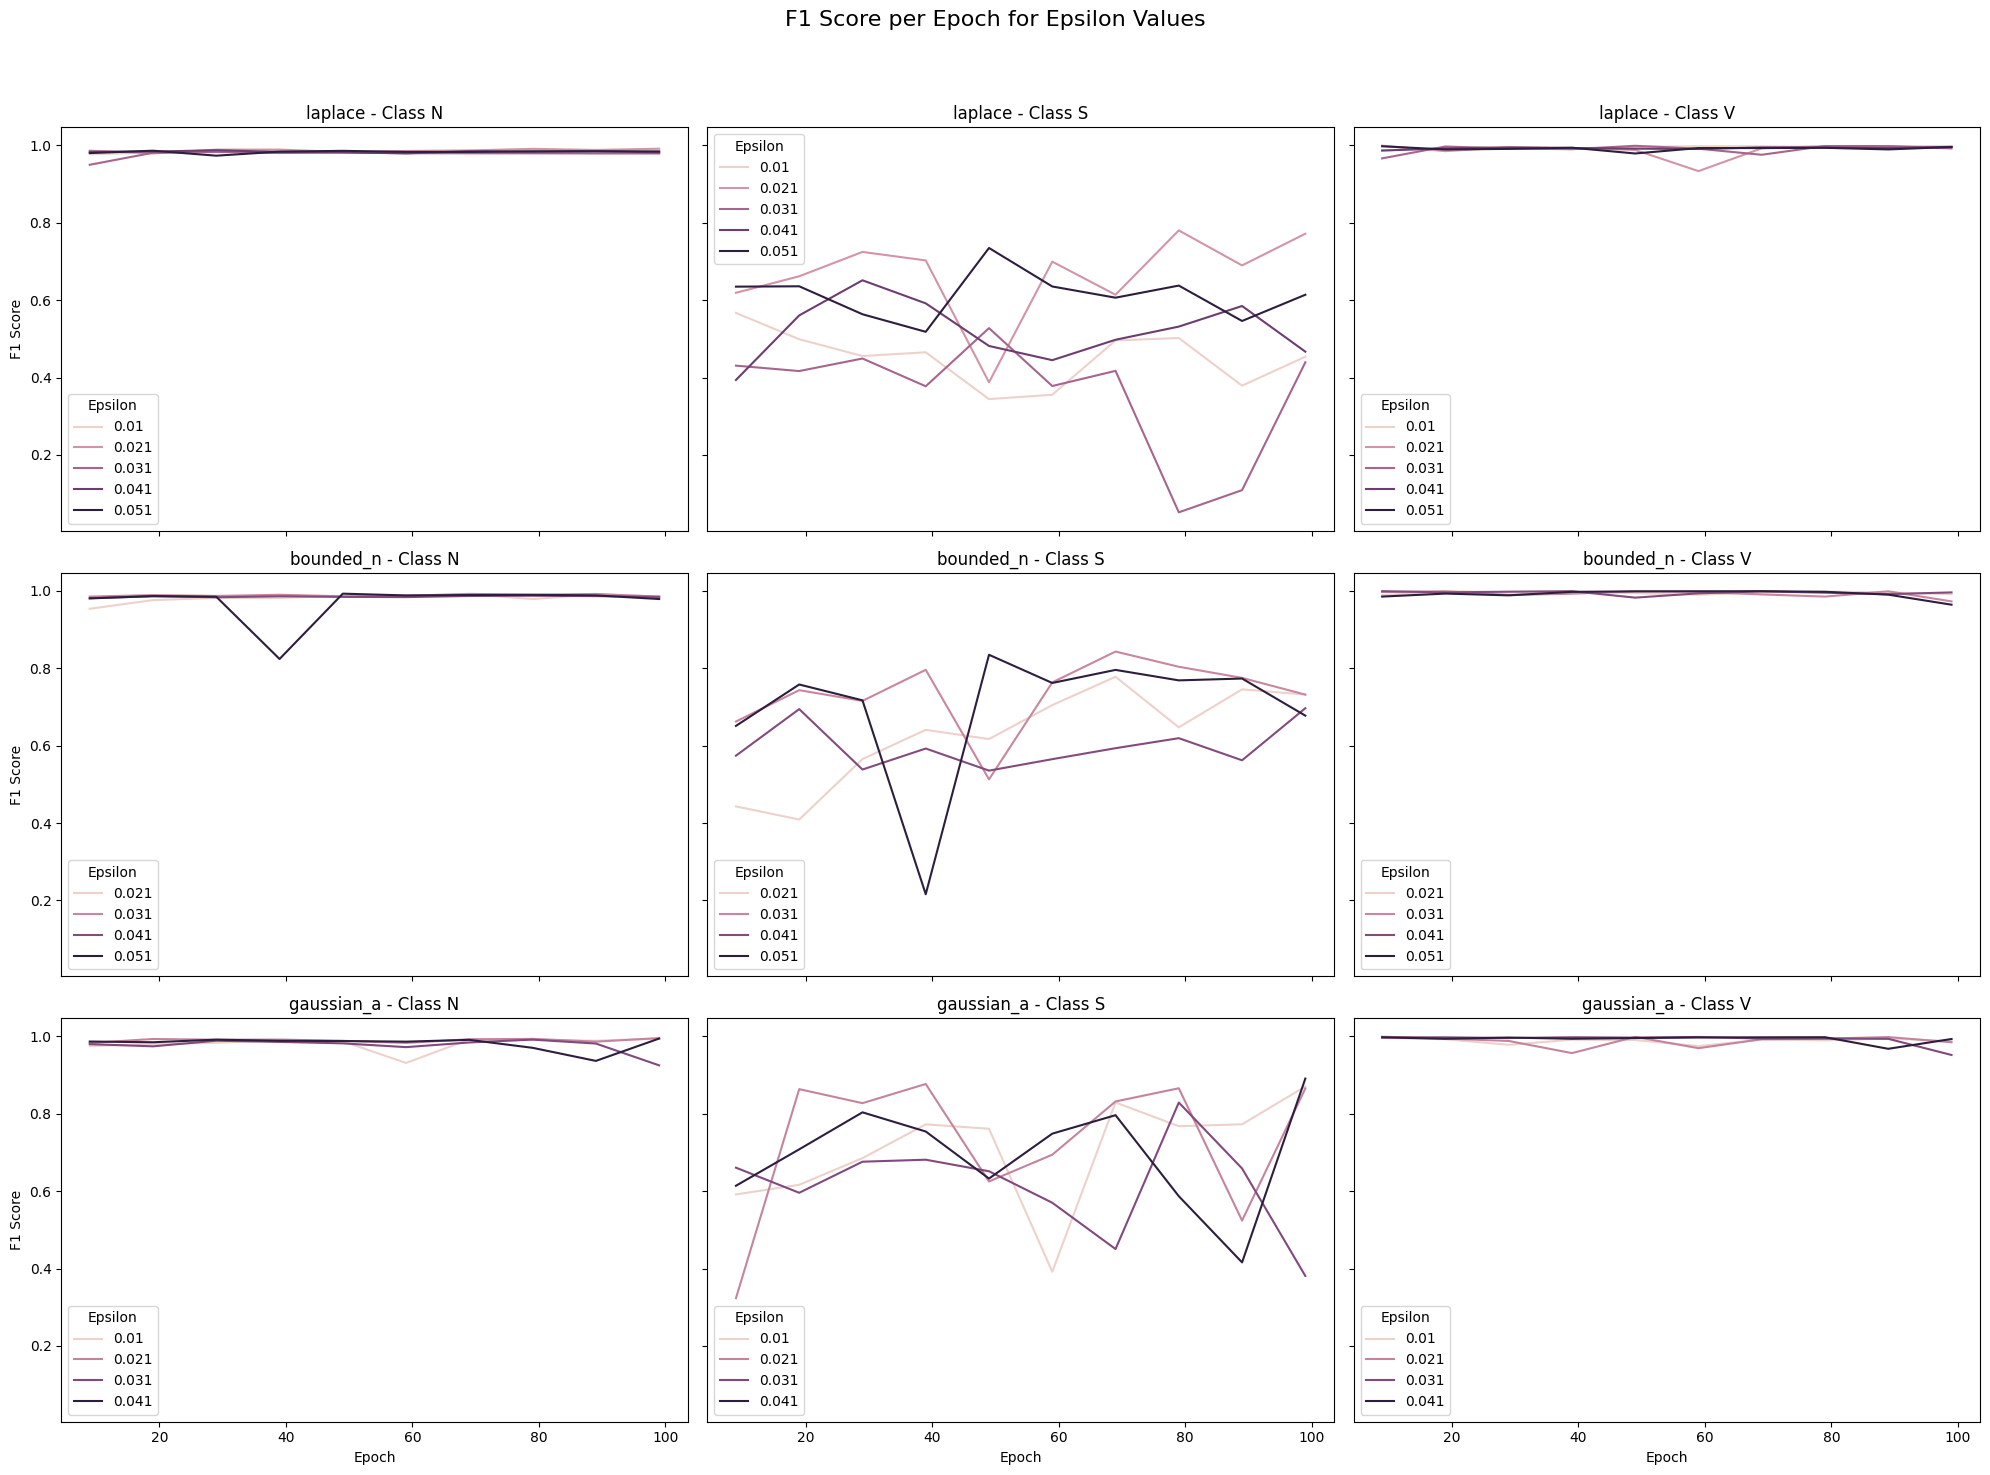

In [16]:
f1_results = df_results[(df_results["Metric"] == "f1_score") & (df_results["Delta"] == 0.4)]
classes = ["N", "S", "V"]

fig, axes = plt.subplots(len(dp_methods), len(classes), figsize=(20, 5 * len(dp_methods)), sharex=True, sharey=True)
fig.suptitle(f"F1 Score per Epoch for Epsilon Values", fontsize=16)

for row_idx, method in enumerate(dp_methods):
    for col_idx, cls in enumerate(classes):
        ax = axes[row_idx][col_idx] if len(dp_methods) > 1 else axes[col_idx]

        subset = f1_results[f1_results["Model"] == f"Inter-{method}"]

        sns.lineplot(
            data=subset,
            x="Epoch",
            y=cls,
            hue="Epsilon",
            ax=ax
        )
        ax.set_title(f"{method} - Class {cls}")

        if col_idx == 0:
            ax.set_ylabel("F1 Score")
        else:
            ax.set_ylabel("")

        if row_idx == (len(dp_methods)-1):
            ax.set_xlabel("Epoch")
        else:
            ax.set_xlabel("")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### F1 Score vs. Epsilons/Deltas -- by DP Mechanism and Class (last epoch only)

#### -- comparing delta

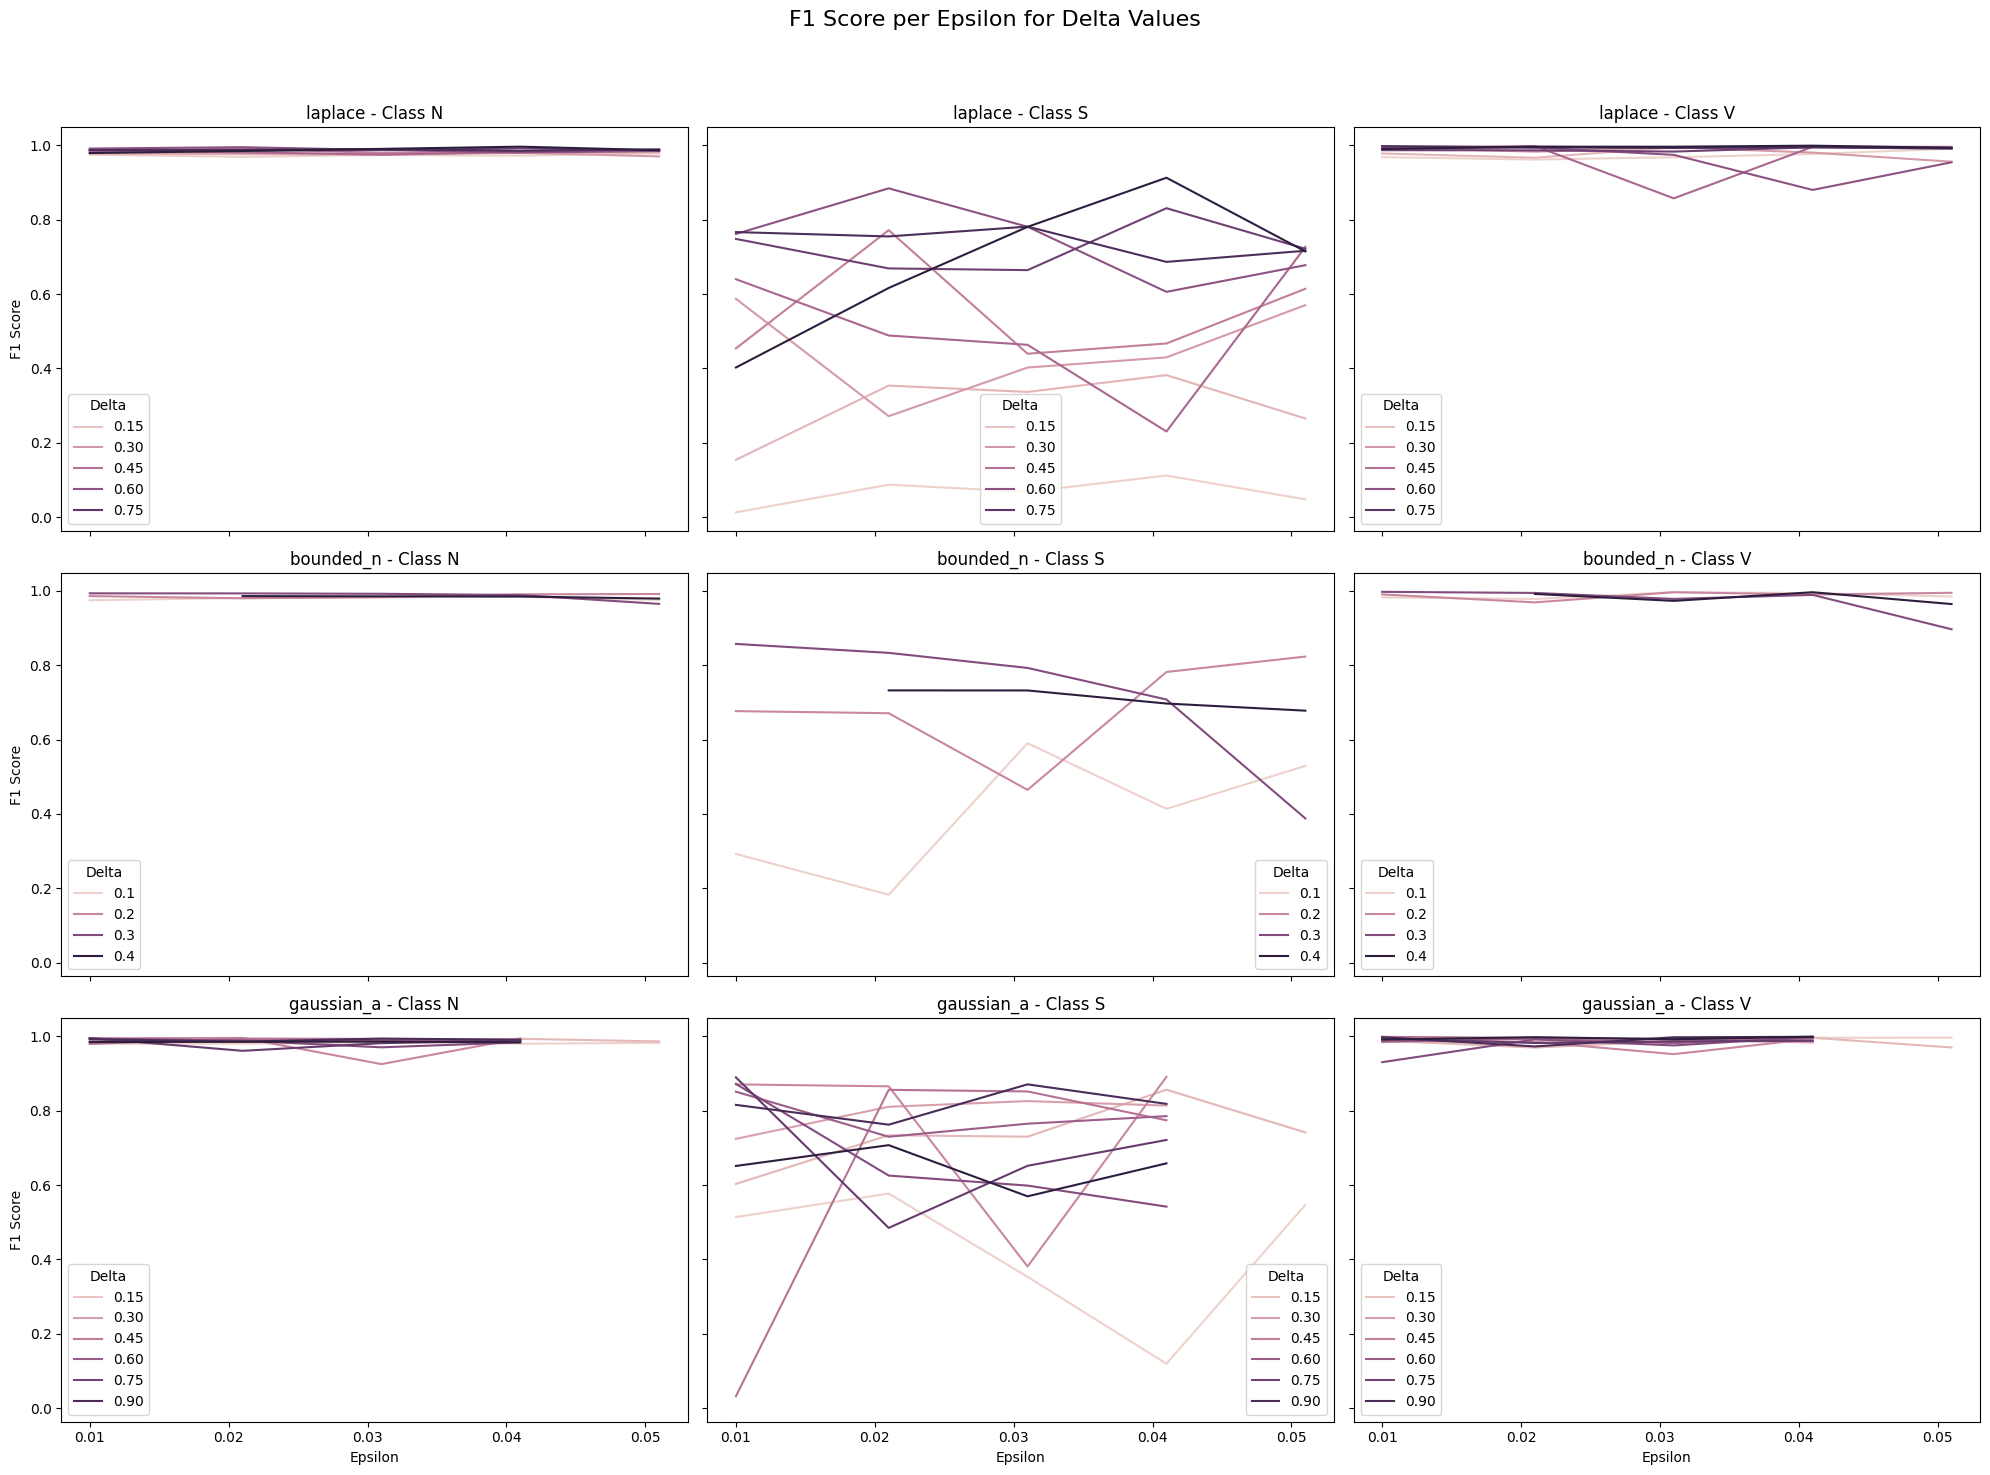

In [17]:
f1_results = df_results[(df_results["Metric"] == "f1_score") & (df_results["Epoch"] == 99)]
classes = ["N", "S", "V"]

fig, axes = plt.subplots(len(dp_methods), len(classes), figsize=(20, 5 * len(dp_methods)), sharex=True, sharey=True)
fig.suptitle(f"F1 Score per Epsilon for Delta Values", fontsize=16)

for row_idx, method in enumerate(dp_methods):
    for col_idx, cls in enumerate(classes):
        ax = axes[row_idx][col_idx] if len(dp_methods) > 1 else axes[col_idx]

        subset = f1_results[f1_results["Model"] == f"Inter-{method}"]

        sns.lineplot(
            data=subset,
            x="Epsilon",
            y=cls,
            hue="Delta",
            ax=ax
        )
        ax.set_title(f"{method} - Class {cls}")
        if col_idx == 0:
            ax.set_ylabel("F1 Score")
        else:
            ax.set_ylabel("")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### -- comparing epsilon 

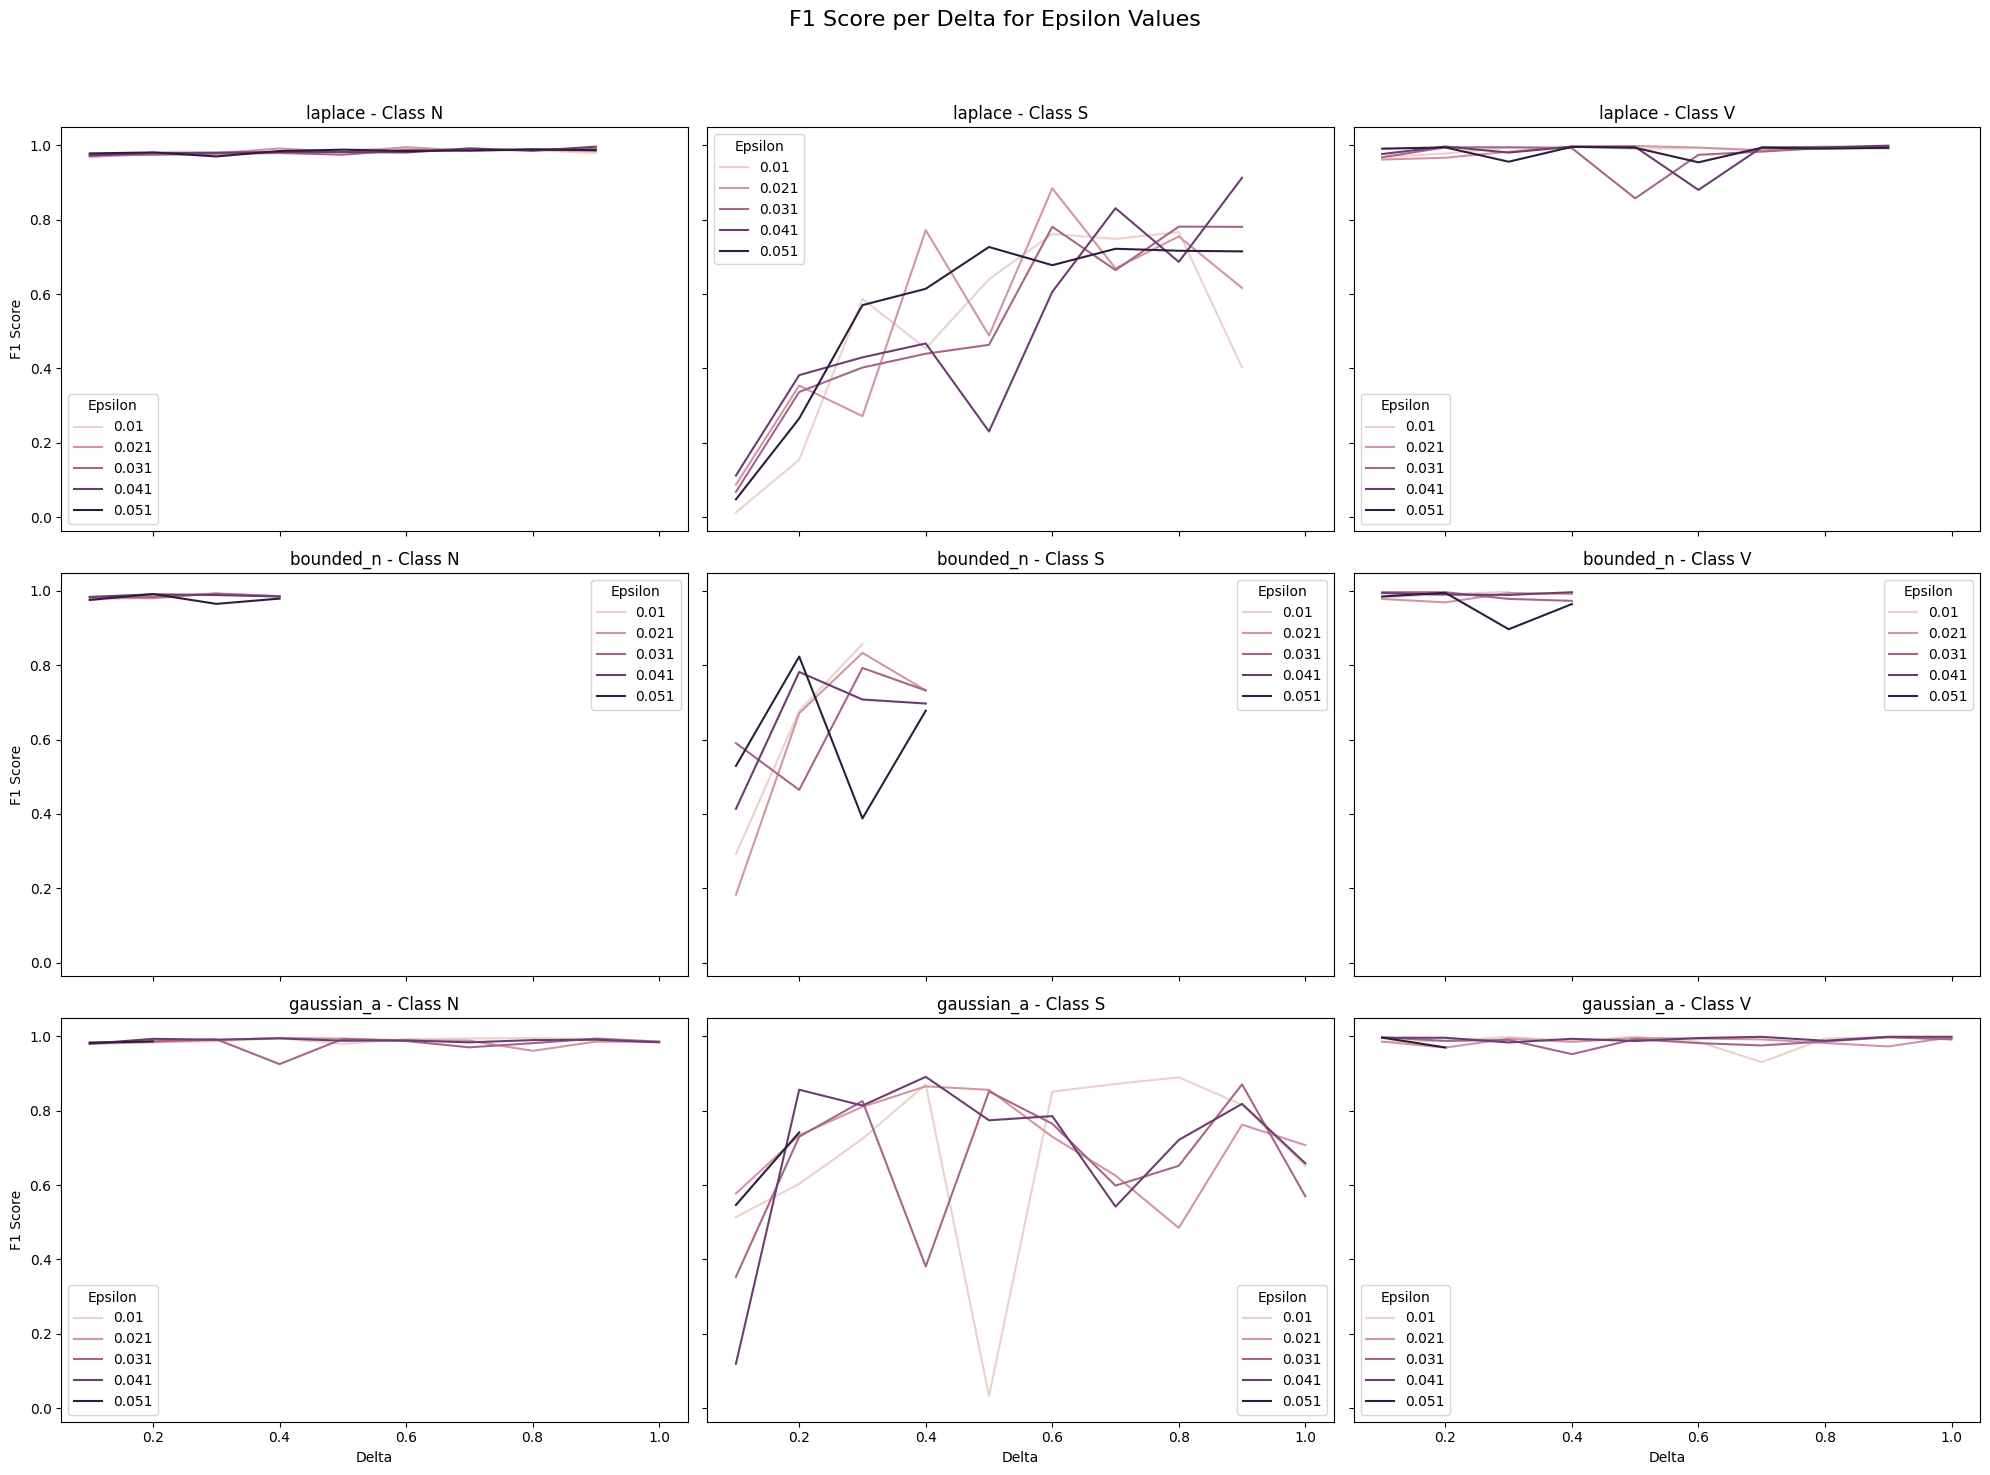

In [18]:
f1_results = df_results[(df_results["Metric"] == "f1_score") & (df_results["Epoch"] == 99)]
classes = ["N", "S", "V"]

fig, axes = plt.subplots(len(dp_methods), len(classes), figsize=(20, 5 * len(dp_methods)), sharex=True, sharey=True)
fig.suptitle(f"F1 Score per Delta for Epsilon Values", fontsize=16)

for row_idx, method in enumerate(dp_methods):
    for col_idx, cls in enumerate(classes):
        ax = axes[row_idx][col_idx] if len(dp_methods) > 1 else axes[col_idx]

        subset = f1_results[f1_results["Model"] == f"Inter-{method}"]

        sns.lineplot(
            data=subset,
            x="Delta",
            y=cls,
            hue="Epsilon",
            ax=ax
        )
        ax.set_title(f"{method} - Class {cls}")

        if col_idx == 0:
            ax.set_ylabel("F1 Score")
        else:
            ax.set_ylabel("")
        
        if row_idx == (len(dp_methods)-1):
            ax.set_xlabel("Delta")
        else:
            ax.set_xlabel("")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## F1 Scores

#### Max / Min per class

In [7]:
f1_last_epoch = df_results[(df_results["Metric"] == "f1_score") & (df_results["Epoch"] == 99)]
max_f1_N = f1_last_epoch[f1_last_epoch["N"] == f1_last_epoch["N"].max()]
max_f1_S = f1_last_epoch[f1_last_epoch["S"] == f1_last_epoch["S"].max()]
max_f1_V = f1_last_epoch[f1_last_epoch["V"] == f1_last_epoch["V"].max()]

max_f1_all = pd.concat([max_f1_N, max_f1_S, max_f1_V], axis=0)

In [8]:
max_f1_S

,Model,Epsilon,Delta,Epoch,Metric,N,S,V,class_average
3239,Inter-laplace,0.041,0.9,99,f1_score,0.996386,0.912798,0.999063,0.969416


In [9]:
max_f1_all

,Model,Epsilon,Delta,Epoch,Metric,N,S,V,class_average
3239,Inter-laplace,0.041,0.9,99,f1_score,0.996386,0.912798,0.999063,0.969416
3239,Inter-laplace,0.041,0.9,99,f1_score,0.996386,0.912798,0.999063,0.969416
9629,Inter-gaussian_a,0.051,0.3,99,f1_score,0.991961,0.771483,0.999379,0.920941


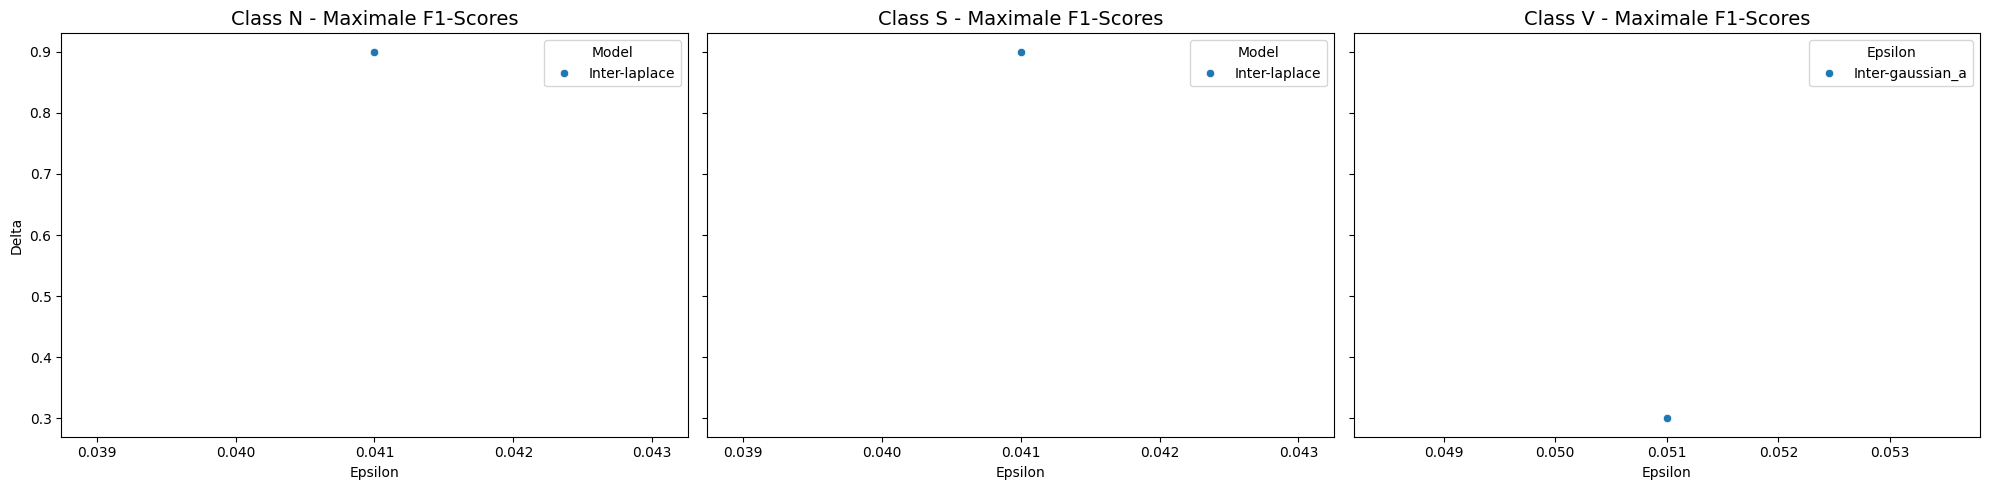

In [10]:
f1_results = df_results[(df_results["Metric"] == "f1_score") & (df_results["Epoch"] == 99)]
classes = ["N", "S", "V"]

fig, axes = plt.subplots(1, len(classes), figsize=(20, 5), sharey=True)

for i, cls in enumerate(classes):

    max_f1 = f1_results[f1_results[cls] == f1_results[cls].max()]
    sns.scatterplot(
        data=max_f1,
        x="Epsilon",
        y="Delta", 
        hue="Model",
        ax=axes[i]
    )
    axes[i].set_title(f"Class {cls} - Maximale F1-Scores", fontsize=14)
    axes[i].set_xlabel("Epsilon")

axes[0].set_ylabel("Delta")
axes[-1].legend(title="Epsilon")

plt.tight_layout()
plt.show()

#### Max / Min on average

In [11]:
f1_last_epoch_sorted = f1_last_epoch.sort_values(by=["class_average"], ascending=False)
top_10 = f1_last_epoch_sorted.head(10)
top_10

,Model,Epsilon,Delta,Epoch,Metric,N,S,V,class_average
3239,Inter-laplace,0.041,0.9,99,f1_score,0.996386,0.912798,0.999063,0.969416
6479,Inter-gaussian_a,0.010,0.8,99,f1_score,0.995502,0.889668,0.994407,0.959859
8819,Inter-gaussian_a,0.041,0.4,99,f1_score,0.994643,0.891212,0.993492,0.959783
1349,Inter-laplace,0.021,0.6,99,f1_score,0.994994,0.884309,0.993964,0.957756
8369,Inter-gaussian_a,0.031,0.9,99,f1_score,0.994041,0.870904,0.997514,0.954153
6119,Inter-gaussian_a,0.010,0.4,99,f1_score,0.994805,0.870798,0.987884,0.951162
4319,Inter-bounded_n,0.010,0.3,99,f1_score,0.993297,0.857213,0.997359,0.949290
7019,Inter-gaussian_a,0.021,0.4,99,f1_score,0.995754,0.865638,0.985169,0.948854
8639,Inter-gaussian_a,0.041,0.2,99,f1_score,0.993410,0.856562,0.996283,0.948751
7109,Inter-gaussian_a,0.021,0.5,99,f1_score,0.994002,0.856191,0.995652,0.948615


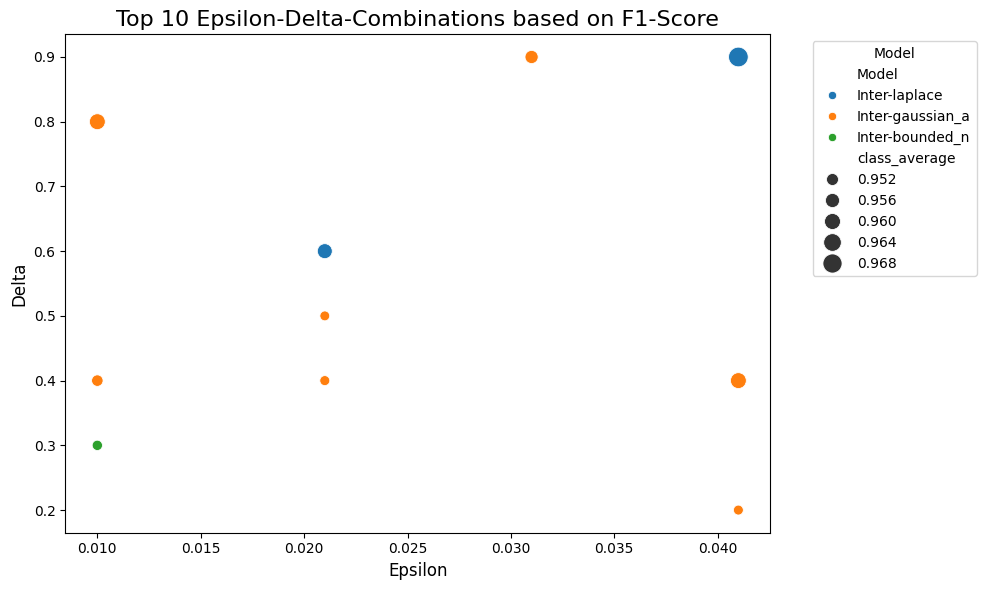

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=top_10,
    x="Epsilon",
    y="Delta",
    hue="Model",
    size="class_average",
    sizes=(50, 200),
    palette="tab10"
)

# Achsentitel und Plot-Titel
plt.title("Top 10 Epsilon-Delta-Combinations based on F1-Score", fontsize=16)
plt.xlabel("Epsilon", fontsize=12)
plt.ylabel("Delta", fontsize=12)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [13]:
low_10 = f1_last_epoch_sorted.tail(10)
low_10

,Model,Epsilon,Delta,Epoch,Metric,N,S,V,class_average
2879,Inter-laplace,0.041,0.5,99,f1_score,0.982062,0.230155,0.995785,0.736001
4409,Inter-bounded_n,0.021,0.1,99,f1_score,0.980721,0.182613,0.978035,0.713790
179,Inter-laplace,0.010,0.2,99,f1_score,0.976677,0.154041,0.978035,0.702918
8549,Inter-gaussian_a,0.041,0.1,99,f1_score,0.980130,0.119344,0.996283,0.698585
2519,Inter-laplace,0.041,0.1,99,f1_score,0.972293,0.111724,0.976580,0.686866
899,Inter-laplace,0.021,0.1,99,f1_score,0.969063,0.087083,0.961694,0.672613
3329,Inter-laplace,0.051,0.1,99,f1_score,0.978198,0.047665,0.990997,0.672287
6209,Inter-gaussian_a,0.010,0.5,99,f1_score,0.979869,0.032154,0.998755,0.670259
1709,Inter-laplace,0.031,0.1,99,f1_score,0.973882,0.067912,0.967898,0.669897
89,Inter-laplace,0.010,0.1,99,f1_score,0.974656,0.012716,0.968208,0.651860


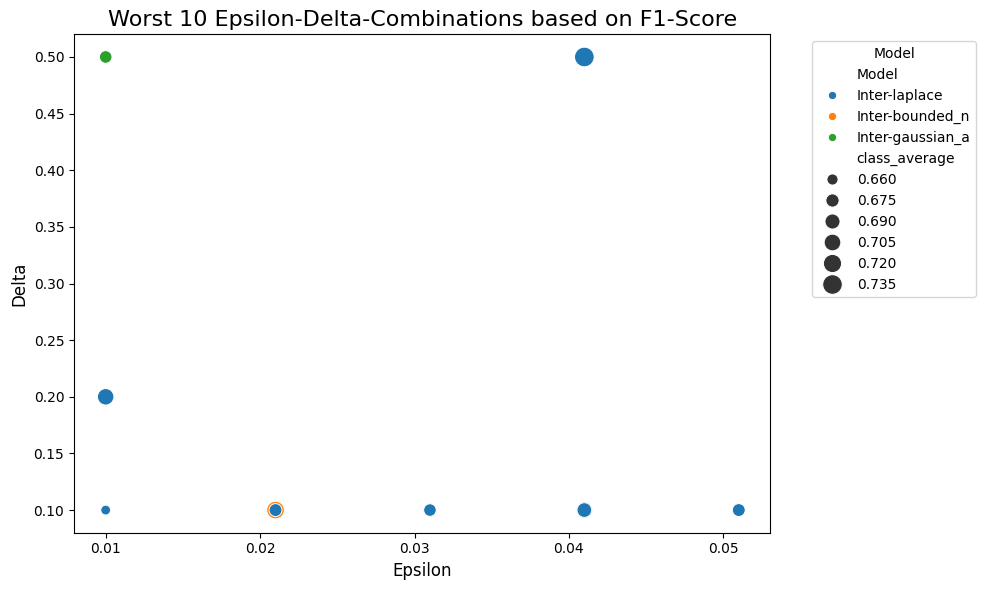

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=low_10,
    x="Epsilon",
    y="Delta",
    hue="Model",
    size="class_average",
    sizes=(50, 200),
    palette="tab10"
)

# Achsentitel und Plot-Titel
plt.title("Worst 10 Epsilon-Delta-Combinations based on F1-Score", fontsize=16)
plt.xlabel("Epsilon", fontsize=12)
plt.ylabel("Delta", fontsize=12)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [33]:
top_10.to_csv("../results_dp/inter_top_10.csv", index=False)

low_10.to_csv("../results_dp/inter_low_10.csv", index=False)

# Shadow Model Performance

In [9]:
def load_shadow_results():
    with open(osj("../results_shadow/interpatient_results.pkl"), 'rb') as f:
        results = pickle.load(f)
    with open(osj("../results_shadow/interpatient_loss.pkl"), 'rb') as f:
        loss = pickle.load(f)
    return results, loss

In [10]:
shadow_results, shadow_loss = load_shadow_results()

In [11]:
shadow_results

{'laplace': {0.041: {0.9: {9: {'avg_acc': np.float32(0.9909444),
     'acc': array([0.98641664, 0.9866666 , 0.99974996], dtype=float32),
     'sens': array([1.      , 0.      , 0.994152], dtype=float32),
     'spec': array([0.75780034, 1.        , 1.        ], dtype=float32),
     'prec': array([0.98581374,        nan, 1.        ], dtype=float32),
     'neg_pred_value': array([1.       , 0.9866666, 0.9997389], dtype=float32),
     'false_pos_rate': array([0.24219966, 0.        , 0.        ], dtype=float32),
     'false_neg_rate': array([0.        , 1.        , 0.00584798], dtype=float32),
     'false_det_rate': array([0.01418629,        nan, 0.        ], dtype=float32),
     'f1_score': array([0.9928562,       nan, 0.9970674], dtype=float32)},
    19: {'avg_acc': np.float32(0.9901944),
     'acc': array([0.9852916 , 0.9855417 , 0.99974996], dtype=float32),
     'sens': array([0.99880815, 0.        , 0.994152  ], dtype=float32),
     'spec': array([0.75780034, 0.99885976, 1.        ], d

In [15]:
loss_records = []
result_records = []

#shadow_results, shadow_loss = load_shadow_results()

# # Extract loss
# for epsilon, deltas in shadow_loss.items():
#     for delta, epochs in deltas.items():

#         last_epoch = max(epochs.keys()) if epochs else None  
#         if last_epoch is None:
#             continue 
        
#         batches = epochs[last_epoch]
#         last_batch = max(batches.keys()) if batches else None  
#         if last_batch is None:
#             continue
        
#         loss = batches[last_batch]
#         loss_records.append({
#             "Model": f"Inter-{mechanism}",
#             "Epsilon": epsilon,
#             "Delta": delta,
#             "Loss": loss
#         })

#     dict_mechanism_results = {epsilon: mechanism_results[epsilon] for epsilon in hp_epsilon_values if epsilon in mechanism_results}

# Extract results
for mechanism, epsilons in shadow_results.items():
    for epsilon, deltas in epsilons.items():
        for delta, epochs in deltas.items():
            for epoch, metrics in epochs.items():
                for metric, values in metrics.items():
                    if metric == "avg_acc":
                        continue
                    else:
                        result_records.append({"Model": f"Shadow-{mechanism}", "Epsilon": epsilon, "Delta": delta, "Epoch": epoch, "Metric": metric, "N": values[0], "S": values[1], "V": values[2]})

shadow_results = pd.DataFrame(result_records)
shadow_losses = pd.DataFrame(loss_records)

In [16]:
shadow_results

,Model,Epsilon,Delta,Epoch,Metric,N,S,V
0,Shadow-laplace,0.041,0.9,9,acc,0.986417,0.986667,0.999750
1,Shadow-laplace,0.041,0.9,9,sens,1.000000,0.000000,0.994152
2,Shadow-laplace,0.041,0.9,9,spec,0.757800,1.000000,1.000000
3,Shadow-laplace,0.041,0.9,9,prec,0.985814,NaN,1.000000
4,Shadow-laplace,0.041,0.9,9,neg_pred_value,1.000000,0.986667,0.999739
...,...,...,...,...,...,...,...,...
895,Shadow-bounded_n,0.010,0.3,99,neg_pred_value,0.946970,0.987471,0.999739
896,Shadow-bounded_n,0.010,0.3,99,false_pos_rate,0.234304,0.002363,0.000000
897,Shadow-bounded_n,0.010,0.3,99,false_neg_rate,0.002468,1.000000,0.005964
898,Shadow-bounded_n,0.010,0.3,99,false_det_rate,0.013337,1.000000,0.000000


In [19]:
f1_shadow_results = shadow_results[(shadow_results["Metric"] == "f1_score") & (shadow_results["Epoch"] == 99)]

In [20]:
f1_shadow_results

,Model,Epsilon,Delta,Epoch,Metric,N,S,V
89,Shadow-laplace,0.041,0.9,99,f1_score,0.990644,NaN,0.997067
179,Shadow-laplace,0.021,0.6,99,f1_score,0.992856,NaN,0.997067
269,Shadow-gaussian_a,0.010,0.8,99,f1_score,0.992850,NaN,0.983701
359,Shadow-gaussian_a,0.010,0.4,99,f1_score,0.989201,NaN,0.997067
449,Shadow-gaussian_a,0.041,0.4,99,f1_score,0.991763,NaN,0.994470
539,Shadow-gaussian_a,0.041,0.2,99,f1_score,0.991851,NaN,0.981638
629,Shadow-gaussian_a,0.031,0.9,99,f1_score,0.992856,NaN,0.997067
719,Shadow-gaussian_a,0.021,0.4,99,f1_score,0.992415,NaN,0.997067
809,Shadow-gaussian_a,0.021,0.5,99,f1_score,0.992997,NaN,0.982288
899,Shadow-bounded_n,0.010,0.3,99,f1_score,0.992068,NaN,0.997009


In [12]:
# Debugging: Überprüfe die Struktur von shadow_results
print("shadow_results Struktur:")
for mechanism, epsilons in shadow_results.items():
    print(f"Mechanism: {mechanism}, Epsilons: {epsilons}")
    if epsilons is None:
        raise ValueError(f"Epsilons für Mechanism {mechanism} ist None.")

    for epsilon, deltas in epsilons.items():
        print(f"  Epsilon: {epsilon}, Deltas: {deltas}")
        if deltas is None:
            raise ValueError(f"Deltas für Epsilon {epsilon} ist None.")

        for delta, epochs in deltas.items():
            print(f"    Delta: {delta}, Epochs: {epochs}")
            if epochs is None:
                raise ValueError(f"Epochs für Delta {delta} ist None.")

            for epoch, metrics in epochs.items():
                print(f"      Epoch: {epoch}, Metrics: {metrics}")
                if metrics is None:
                    raise ValueError(f"Metrics für Epoch {epoch} ist None.")
                

shadow_results Struktur:
Mechanism: laplace, Epsilons: {0.041: {0.9: {9: {'avg_acc': np.float32(0.9909444), 'acc': array([0.98641664, 0.9866666 , 0.99974996], dtype=float32), 'sens': array([1.      , 0.      , 0.994152], dtype=float32), 'spec': array([0.75780034, 1.        , 1.        ], dtype=float32), 'prec': array([0.98581374,        nan, 1.        ], dtype=float32), 'neg_pred_value': array([1.       , 0.9866666, 0.9997389], dtype=float32), 'false_pos_rate': array([0.24219966, 0.        , 0.        ], dtype=float32), 'false_neg_rate': array([0.        , 1.        , 0.00584798], dtype=float32), 'false_det_rate': array([0.01418629,        nan, 0.        ], dtype=float32), 'f1_score': array([0.9928562,       nan, 0.9970674], dtype=float32)}, 19: {'avg_acc': np.float32(0.9901944), 'acc': array([0.9852916 , 0.9855417 , 0.99974996], dtype=float32), 'sens': array([0.99880815, 0.        , 0.994152  ], dtype=float32), 'spec': array([0.75780034, 0.99885976, 1.        ], dtype=float32), 'prec'